In [1]:
import numpy as np
import wave
import librosa
import librosa.display
from librosa.core import stft
import matplotlib.pyplot as plt
import scipy 
import matplotlib.cm as cm

In [2]:
def _wav2array(nchannels, sampwidth, data):
    """data must be the string containing the bytes from the wav file."""
    num_samples, remainder = divmod(len(data), sampwidth * nchannels)
    if remainder > 0:
        raise ValueError('The length of data is not a multiple of '
                         'sampwidth * num_channels.')
    if sampwidth > 4:
        raise ValueError("sampwidth must not be greater than 4.")

    if sampwidth == 3:
        a = np.empty((num_samples, nchannels, 4), dtype=np.uint8)
        raw_bytes = np.fromstring(data, dtype=np.uint8)
        a[:, :, :sampwidth] = raw_bytes.reshape(-1, nchannels, sampwidth)
        a[:, :, sampwidth:] = (a[:, :, sampwidth - 1:sampwidth] >> 7) * 255
        result = a.view('<i4').reshape(a.shape[:-1])
    else:
        # 8 bit samples are stored as unsigned ints; others as signed ints.
        dt_char = 'u' if sampwidth == 1 else 'i'
        a = np.fromstring(data, dtype='<%s%d' % (dt_char, sampwidth))
        result = a.reshape(-1, nchannels)
    return result


def readwav(file):
    """
    Read a wav file.
    Returns the frame rate, sample width (in bytes) and a numpy array
    containing the data.
    This function does not read compressed wav files.
    """
    wav = wave.open(file)
    rate = wav.getframerate()
    nchannels = wav.getnchannels()
    sampwidth = wav.getsampwidth()
    nframes = wav.getnframes()
    data = wav.readframes(nframes)
    wav.close()
    array = _wav2array(nchannels, sampwidth, data)
    return rate, sampwidth, array

In [330]:
audio = readwav('/users/josephcleveland/Desktop/SAW.wav')[2]
print(audio.T[0])
audio = audio.astype(np.floating)
print(audio.shape)



[0 0 0 ... 0 0 0]
(331622, 1)


/Users/josephcleveland/Summer/venv/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


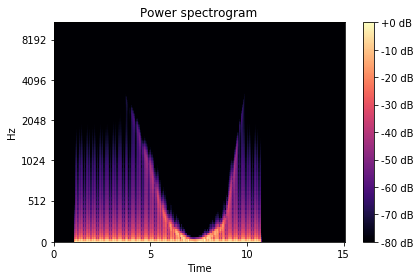

In [331]:
numBins = 128

Spectogram = np.abs(librosa.feature.melspectrogram(audio.T[0], sr=44100, n_mels=numBins))
librosa.display.specshow(librosa.amplitude_to_db(Spectogram,
                        ref=np.max),
                          y_axis='mel', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

/Users/josephcleveland/Summer/venv/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


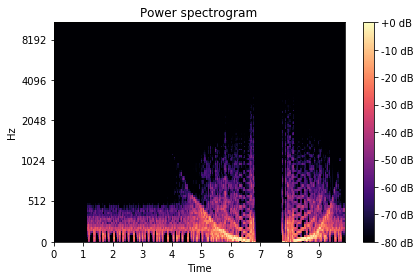

In [341]:
recaudio = readwav('/users/josephcleveland/Desktop/recreation.wav')[2]
recaudio = recaudio.astype(np.floating)


recspec = np.abs(librosa.feature.melspectrogram(recaudio.T[0], n_mels=numBins))
librosa.display.specshow(librosa.amplitude_to_db(recspec,
                        ref=np.max),
                          y_axis='mel', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

In [333]:
"""Finding frequency envelope for """

ref_freqs_bins = librosa.mel_frequencies(n_mels = numBins)
print(ref_freqs_bins)

[    0.            26.19978713    52.39957426    78.59936139
   104.79914851   130.99893564   157.19872277   183.3985099
   209.59829703   235.79808416   261.99787129   288.19765842
   314.39744554   340.59723267   366.7970198    392.99680693
   419.19659406   445.39638119   471.59616832   497.79595545
   523.99574257   550.1955297    576.39531683   602.59510396
   628.79489109   654.99467822   681.19446535   707.39425247
   733.5940396    759.79382673   785.99361386   812.19340099
   838.39318812   864.59297525   890.79276238   916.9925495
   943.19233663   969.39212376   995.59191089  1022.72769586
  1050.73771015  1079.51485035  1109.08012615  1139.45512266
  1170.66201615  1202.72359026  1235.6632526   1269.50505185
  1304.27369535  1339.9945671   1376.6937463   1414.39802641
  1453.13493468  1492.93275229  1533.82053494  1575.82813412
  1618.98621886  1663.32629817  1708.88074397  1755.68281482
  1803.7666801   1853.16744504  1903.92117631  1956.06492834
  2009.63677042  2064.6758

In [334]:
print(Spectogram.shape)
spectLength = Spectogram.shape[1]

sampRate = 44100
envStepLength = audio.shape[0]/sampRate /spectLength
print(envStepLength)

(128, 648)
0.011604588337392571


In [335]:
"""Finding peaks"""
peaks_index = []
for i in range (0,spectLength):
    peaks_one_slice,_ = scipy.signal.find_peaks(Spectogram [:,i], 32)
    peaks_index.append(peaks_one_slice)
print(peaks_index)

[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype

In [336]:
""" Find longest set of peaks, pmax"""
pmax = len(peaks_index[0])

for i in range(len(peaks_index)):
    if len(peaks_index[i]) > pmax:
        pmax = len(peaks_index[i])

In [337]:

f = open('freqs_env.csv', 'w')
for i in range (0, spectLength):
    freq = ref_freqs_bins[peaks_index[i]]
    colCount = 0
    for p in freq:
        f.write(str(p) + " ")
        colCount += 1
    for pad in range(pmax - colCount):
        f.write(str(0) + " ")
    f.write("\n")

#np.savetxt('freqs_env.csv', freqs_env, delimiter = ',', fmt='%s')

f.close()

In [338]:
        
amp_env = np.zeros((spectLength, pmax))
for i in range (0, spectLength):
    amp_one_slice = Spectogram[peaks_index[i], i]
    amp_env[i, :amp_one_slice.shape[0]] = amp_one_slice
    #amp_env.append(amp_one_slice)
    
print(amp_env[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [339]:
localmax = []
max_val = np.array(amp_env)

for i in range (0,numBins):
    max = np.amax(amp_env[i])
    localmax.append(max)
    
#normalized_amp_env = amp_env / np.amax(localmax)
normalized_amp_env = [x / np.amax(localmax) for x in amp_env]

print(np.amax(localmax))
f = open('amp_env.csv', 'w')
count = 0
for i in range (0, spectLength):
    amp = normalized_amp_env[i]
    colCount = 0
    for p in amp:
        f.write(str(p) + " ")
        colCount += 1
    for pad in range(pmax - colCount):
        f.write(str(0) + " ")
    f.write("\n")
    count += 1
    
print(count)

f.close()

973054059.6995666
648
